## Choosing EU ETS vs Carbon TAX
EU ETS start only at 2005 and Carbon Tax depends on countries that have already implemented it but could go as early as 1990.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

carbon_pricing_data = pd.read_excel('./ggdp_data/world_bank/world_bank_carbon_pricing.xlsx', header=1,
                                    sheet_name='Compliance_Price', na_values='-')
carbon_pricing_data = carbon_pricing_data.set_index('Name of the initiative').T
carbon_pricing_data.rename(columns=lambda x: str.lower(x.replace(' ', '_')), inplace=True)
#dropping all metadata rows
carbon_pricing_data = carbon_pricing_data.iloc[7:]
carbon_pricing_data = carbon_pricing_data.apply(pd.to_numeric)
carbon_pricing_data.index = [str(x) for x in carbon_pricing_data.index]

eu_ets = carbon_pricing_data['eu_ets']
finland_carbon_tax = carbon_pricing_data['finland_carbon_tax']
#Finland has two types of carbon tax: Transport fuels, heating fuels which are the same across the whole series
finland_carbon_tax = finland_carbon_tax.iloc[:, 0]

In [2]:
#checking to see if EU ETS can proxy for carbon tax or the other way round. Does any one of them hold and additional information?
ets_joined_carbon_tax = pd.DataFrame(eu_ets).join(finland_carbon_tax)
ets_joined_carbon_tax = ets_joined_carbon_tax.dropna()
ets_joined_carbon_tax.head()

model = sm.OLS.from_formula('eu_ets ~ finland_carbon_tax', data=ets_joined_carbon_tax)
results = model.fit()
results.summary()


C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 eu_ets   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     3.365
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0842
Time:                        17:58:24   Log-Likelihood:                -86.898
No. Observations:                  19   AIC:                             177.8
Df Residuals:                      17   BIC:                             179.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.4432     11.154      0.667      0.514     -16.090      30.976
finland_carbon_tax     0.3522      0.192      1.834      0.084      -0.053       0.757
==============================================================================
Omnibus:                        6.489   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.314
Skew:                           1.139   Prob(JB):                        0.116
Kurtosis:                       3.508   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysing Results
I was looking to see if ets and carbon tax are very correlated, if they are then I could probably assume that one of them proxies for the other. We can see that linear relationship between the variables is insignificant. Meaning that they don't proxy linearly for each other. Thus I should probably use one of them or a combination of both when calculating the GGDP results.

## Calculating GGDP
The base formula which I'm going to use is this: $ GGDP = GDP - KtCO_{2} \cdot P_{tCO_2} - Twaste \cdot 74 kWh \cdot P_{1 kWh elec} - GNI \cdot \% NRD/100 $

First term - air pollution
Second Term - waste pollution translated into electricity cost
Third Term - Natural resource depletion

The 74 figure is based on different papers: check this

Managed to find all the data for this: arises the question of what data to include and how.

The problems with this base formula are:
1. doesn't account for defensive costs - the cost of restoring and protecting the environment. Need to find figures for this.
2. the figure 74 isn't really based on anything concrete (the citing is quite unclear)
3. no accounting for green innovation - not even sure if I want to add this, but perhaps I should

The main problem with actually deriving GGDP is data availability and lack of accounting standard that can be implemented using available data.

### Making some adjustments to get more accurate data

The term $Natural Resource Depletion Cost = GNI \cdot \% NRD/100 $ is in effect caulculated using current dollar terms of GNI and not GNI[PPP] which changes the calculation method and the units. So insted we will now just directly calculate $NRD Cost = C_{forest} + C_{mineral} + C_{energy}$ (as the World Bank calculates it in the WDI database).
In addition, we will not use the figure 74kWh because it's not really clear what it's based on, but I found a paper that explains that it's possible to create a closed self-sustainable system which generates 800kWh per 2 tons/hour waste -> 400 kWh from 1 ton/hour of waste.

Particulate Emission Damage - another available series is particulate emission damage, which in my opinion accounts for some of the health adjustments to GDP as a result of using non-green drivers. It is not necessarily required so I will first calculate GGDP without it and then add it to see how it affects it.

Defensive Costs - Defensive costs for finland started being recorded only from around 2014 which doesn't allow for much data. The question that arises is whether it should be accounted for at all since the data is in fact incomplete (Finland didn't really only start investing in defensive costs only since 2014). It would be possible to simulate some of the data for this, but I don't think it's a good idea because we have so little samples for this data.

Essentially the formula we are going to use is: \
$ GGDP_{t} = GDP_{t} - C_{e,t}-C_{r,t}-C_{s,t} $ \
$ C_{e,t} = CO_{2} \cdot P_{co2} $ \
$ C_{r,t} = NRD Cost_{t} = C_{forest,t} + C_{mineral,t} + C_{energy,t}$ \
$ C_{s,t} = Particulate Damage Cost $


In [3]:
wdi_data = pd.read_excel('./ggdp_data/world_bank/P_Data_Extract_From_World_Development_Indicators_v2.xlsx', header=0,
                         sheet_name='Data', na_values='..')
wdi_data = wdi_data.set_index('Country Name').T
wdi_data = wdi_data.drop(['Series Code'])
wdi_data = wdi_data.rename({"Series Name": "variable_name"})
wdi_data = wdi_data.rename(index=lambda x: x[:y] if (y := x.find(' ')) != -1 else x)
wdi_data = wdi_data.dropna(axis='columns', how='all')


def replace_values_from_dict(curr_value, value_dict: dict):
    try:
        return value_dict[curr_value]
    except KeyError:
        return curr_value


# wdi_variables_to_replace = {'GNI, PPP (current international $)': 'gni_ppp',
#                             'Adjusted savings: carbon dioxide damage (% of GNI)': 'as_co2_damage_gni',
#                             'Adjusted savings: natural resources depletion (% of GNI)': 'as_nrd_gni',
#                             'Adjusted savings: particulate emission damage (% of GNI)': 'as_ped_gbi',
#                             'GNI (current US$)': 'gni_dollar',
#                             'CO2 emissions (kt)': 'co2_kt',
#                             'Total greenhouse gas emissions (kt of CO2 equivalent)': 'total_gge_kt',
#                             'GDP, PPP (current international $)': 'gdp_ppp',
#                             'GDP (current US$)': 'gdp_dollar',
#                             'PPP conversion factor, GDP (LCU per international $)': 'ppp_lcu_to_dollar'}

#I refer to international dollar as ppp
wdi_variables_to_replace = {'CO2 emissions (kt)': 'co2_kt',
                            'GDP (current US$)': 'gdp_dollar',
                            'Adjusted savings: energy depletion (current US$)': 'as_energy_depletion',
                            'Adjusted savings: mineral depletion (current US$)': 'as_mineral_depletion',
                            'Adjusted savings: net forest depletion (current US$)': 'as_forest_depletion',
                            'PPP conversion factor, GDP (LCU per international $)': 'lcu_to_ppp',
                            'Adjusted savings: particulate emission damage (current US$)': 'as_particulate_emission_damage',
                            'GDP, PPP (current international $)': 'gdp_ppp',
                            'GDP (current LCU)': 'gdp_lcu'}

#def lower_only_letters(curr_str:str):


#renaming variables
wdi_data.loc['variable_name'] = (wdi_data.loc['variable_name']).apply(replace_values_from_dict,
                                                                      args=(wdi_variables_to_replace,))


def change_col_names_to_country(df: pd.DataFrame):
    column_name_list = []
    curr_col_name: str
    for curr_col_name, curr_series in df.items():
        #'country-name'_'variable-name'
        new_column_name = f'{curr_col_name.lower()}_{curr_series["variable_name"]}'
        column_name_list.append(new_column_name)
    df.columns = column_name_list


#combine all finland data into one dataframe to avoid problems with dates
finland_data = wdi_data['Finland']
change_col_names_to_country(finland_data)
finland_data = finland_data.drop(index=['Country', 'variable_name'])
finland_data = finland_data.join(finland_carbon_tax, how='left')

finland_data = finland_data.apply(pd.to_numeric)

#calculating natural resource depletion cost in dollars
finland_data['finland_as_nrd_cost'] = (finland_data['finland_as_energy_depletion'] +
                                       finland_data['finland_as_mineral_depletion'] +
                                       finland_data['finland_as_forest_depletion'])

#use this to convert from EUR to current dollar
finland_data['finland_dollar_to_lcu'] = finland_data['finland_gdp_dollar'] / finland_data['finland_gdp_lcu']
finland_data['finland_ppp_to_dollar'] = 1 / (finland_data['finland_dollar_to_lcu'] * finland_data['finland_lcu_to_ppp'])


There's a problem with calculating waste because not enough waste data is available in order to constrcut the waste cost term. So there's a need to do imputation.
I thought it would make sense to do the imputation by regressing waste on gdp, since as the country has more economic output the more waste it's going to have.

I tried regressing Net Waste on GGDP[PPP] but I couldn't reject the null so decided not to use that model. But when I did a log transform it worked better, now I can reject both hypotheses and we get the model: $\log(Net Waste) = -14.4018 + 1.2512 * \log(GDP[PPP]) $. We get a very high R-squared as well.
We can use this result to fill in the missing values all the way to 1990.

In [4]:
#Waste calculation
# Waste generation data preparation and projections
waste_gen_data = pd.read_csv('./ggdp_data/eurostat_generation_of_waste_by_category.csv')
waste_treatment_data = pd.read_csv('./ggdp_data/eurostat_waste_treatment_by_waste_category.csv')

#getting Finland's total waste generation
finland_gen_total = waste_gen_data[(waste_gen_data['geo'] == 'FI') & (waste_gen_data['waste'] == 'TOTAL')]
finland_gen_total.index = finland_gen_total['TIME_PERIOD']
#getting Finland's total energy recovery from waste, since we are pricing waste through energy prices.
finland_energy_recovery = waste_treatment_data[
    (waste_treatment_data['geo'] == 'FI') & (waste_treatment_data['wst_oper'] == 'RCV_E')]
finland_energy_recovery.index = finland_energy_recovery['TIME_PERIOD']

net_waste_data = pd.DataFrame()
#calculating net waste: net_waste = generated_waste - energy_recovered_from_waste
net_waste_data['finland_net_waste'] = finland_gen_total['OBS_VALUE'] - finland_energy_recovery['OBS_VALUE']

net_waste_data.index = [str(x) for x in net_waste_data.index]

#is GDP correlated with waste

gdp_waste_data = net_waste_data.join(finland_data['finland_gdp_ppp'])

gdp_waste_data['finland_net_waste_log'] = np.log(gdp_waste_data['finland_net_waste'])
gdp_waste_data['finland_gdp_ppp_log'] = np.log(gdp_waste_data['finland_gdp_ppp'])

model = sm.OLS.from_formula('finland_net_waste_log ~ finland_gdp_ppp_log', data=gdp_waste_data)
results = model.fit()
results.summary()

C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     finland_net_waste_log   R-squared:                       0.811
Model:                               OLS   Adj. R-squared:                  0.784
Method:                    Least Squares   F-statistic:                     30.07
Date:                   Thu, 23 May 2024   Prob (F-statistic):           0.000923
Time:                           17:58:24   Log-Likelihood:                 7.3751
No. Observations:                      9   AIC:                            -10.75
Df Residuals:                          7   BIC:                            -10.36
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -14.4018      5.962     -2.416      0.046     -28.499      -0.304
finland_gdp_ppp_log     1.2512      0.228      5.483      0.001       0.712       1.791
==============================================================================
Omnibus:                        1.157   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                0.678
Skew:                           0.207   Prob(JB):                        0.713
Kurtosis:                       1.721   Cond. No.                     3.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
#adding the model from the regression to the data
finland_data['finland_gdp_ppp_log'] = np.log(finland_data['finland_gdp_ppp'])
finland_data['net_waste_log'] = results.params['Intercept'] + finland_data['finland_gdp_ppp_log'] * results.params[
    'finland_gdp_ppp_log']
finland_data['net_waste'] = np.exp(finland_data['net_waste_log'])


### Electricity Price
We use electricity price to be able to price solid waste. The problem is electricity price is tiered so the calculation has to be done accordingly. What I plan on doing is taking the fractional part of the total waste converted to electricity respective to house-hold use and industrial use in Finland and then look at each one of them as if it were a single consumer. This is an obvious over-simplification but otherwise there is no way of calculating it because of a lack of data.

In [6]:
from electrcity_processing_functions import tax_tier_map, process_electricity_df, process_electricity_consumption_df

elec_hh_pre_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_hh_pre_2007.csv', header=0)
elec_hh_pre_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_hh_pre_2007)
elec_hh_post_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_hh_post_2007.csv',
                                header=0)

#there's overlap with the two dataframe: both have 2007 data
elec_hh_pre_2007_index_to_drop = elec_hh_pre_2007_processed[elec_hh_pre_2007_processed['year'] == '2007'].index
elec_hh_pre_2007_processed = elec_hh_pre_2007_processed.drop(index=elec_hh_pre_2007_index_to_drop)

elec_hh_post_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_hh_post_2007)
elec_hh = pd.concat([elec_hh_post_2007_processed, elec_hh_pre_2007_processed])
elec_hh = elec_hh.replace({'tax_tier': tax_tier_map})
elec_hh['tax_tier'] = pd.to_numeric(elec_hh['tax_tier'])
elec_hh['year'] = pd.to_numeric(elec_hh['year'])

elec_nh_pre_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_nh_pre_2007.csv')
elec_nh_pre_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_nh_pre_2007)
elec_nh_post_2007 = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_price_nh_post_2007.csv')
elec_nh_post_2007_processed = process_electricity_df(country_code='FI', elec_df=elec_nh_post_2007)
elec_nh = pd.concat([elec_nh_post_2007_processed, elec_nh_pre_2007_processed])
elec_nh = elec_nh.replace({'tax_tier': tax_tier_map})
elec_nh['tax_tier'] = pd.to_numeric(elec_nh['tax_tier'])
elec_nh['year'] = pd.to_numeric(elec_nh['year'])

elec_consumption = pd.read_csv('./ggdp_data/eurostat_electricity/eurostat_electricity_consumption.csv', header=0)
elec_consump_processed = process_electricity_consumption_df(country_code='FI', df=elec_consumption)


C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'year'] = filtered_df['TIME_PERIOD'].apply(lambda x: x[:x.find('-')])
C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df['price'] = filtered_df.loc[:, 'price'].fillna(method='ffill')
C:\Users\yarde\PycharmProjects\ggdp_research\electrcity_processing_functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

When looking at electricity prices I only decided to look at electricity prices for household and non-household consumptio because the cost for household vs non-hosehold electricty prices are different. This presents a bit of a challange in pricing electricity becasue it raises the question of which rate to use. I decided to take the relative part of household and non-household from the WTE output. For example if HH is 2/3 of the total consumption and NH is 1/3 so we will price 2/3 of WTE using HH pricess and a 1/3 of WTE using NH prices.

In [7]:
from numpy import nan


#some electricity prices for post 2007 data are missing for finland data so I took official data from Statistics Finland’s free-of-charge statistical databases
# I plan on merging the data together to get as much data as possible
def process_fin_stat_df(df: pd.DataFrame) -> pd.DataFrame:
    df['year'] = df['Month'].apply(lambda x: x[:x.find('M')])
    df = df.replace({'..': nan})
    df = df.dropna(axis='columns', how='all')
    df = df.drop(columns=['Month'])
    df = df.apply(pd.to_numeric)
    average_yearly_price_df = df.groupby(['year'], as_index=False).mean()
    average_yearly_with_tax_tier_rows = []

    for index, row in average_yearly_price_df.iterrows():
        tax_tiers = list(row.index.values)
        tax_tiers.remove('year')
        for tier in tax_tiers:
            average_yearly_with_tax_tier_rows.append(
                {'year': row['year'],
                 'tax_tier': tier,
                 'price': row[tier] / 100,
                 'currency': 'EUR'}
            )
    return pd.DataFrame(average_yearly_with_tax_tier_rows)

    #for each year we have a price for each consumption range


fin_stat_elec_price_hh = pd.read_csv('ggdp_data/finalnd_statistics_db/finalnd_statistics_hh_elec_prices.csv', header=0)
fin_stat_elec_price_hh = process_fin_stat_df(fin_stat_elec_price_hh)

fin_stat_elec_price_nh = pd.read_csv('ggdp_data/finalnd_statistics_db/finalnd_statistics_nh_elec_prices.csv', header=0)
fin_stat_elec_price_nh = process_fin_stat_df(fin_stat_elec_price_nh)

#combining both datasets
#for hh we start at 2009 for official dataset, so anything prior to that will be taken from processed dataset


hh_elec_filtered_to_combine_eurostat = elec_hh[(elec_hh['currency'] == 'EUR') & (elec_hh['year'] < 2009)]
hh_elec_combined = pd.concat([hh_elec_filtered_to_combine_eurostat, fin_stat_elec_price_hh])
hh_elec_combined = hh_elec_combined.sort_values(by=['year', 'tax_tier'])
hh_elec_combined['tax_tier'] = pd.to_numeric(hh_elec_combined['tax_tier'])

#


nh_elec_filtered_to_combine_eurostat = elec_nh[(elec_nh['currency'] == 'EUR') & (elec_nh['year'] < 2008)]

index_of_missing_val = fin_stat_elec_price_nh[
    (fin_stat_elec_price_nh['year'] == 2008) & (fin_stat_elec_price_nh['tax_tier'] == '20000')].index
price_for_filling = \
    elec_nh[(elec_nh['year'] == 2008) & (elec_nh['currency'] == 'EUR') & (elec_nh['tax_tier'] == 20000)].squeeze(
        axis=0)[
        'price']
fin_stat_elec_price_nh.loc[index_of_missing_val, 'price'] = price_for_filling

nh_elec_combined = pd.concat([nh_elec_filtered_to_combine_eurostat, fin_stat_elec_price_nh])
nh_elec_combined['tax_tier'] = pd.to_numeric(nh_elec_combined['tax_tier'])

## Units for GGDP
- Carbon pricing - carbon tax is dollar/kilo-ton of CO2 emission
- waste cost - is in dollars
- NRD - in percentage of GDP
- GDP - can be in ppp or dollars. I'll choose to work with dollars for uniformity of the data
I want to work with real GGDP, GGDP[PPP] in order to get real growth rates and not just nominal ones. This is especially important when comparing different countries or scenrios since if a specific policy will increase GGDP growth but might actually cause an infaltion increase which is greater, thus actually shrinking real GGDP.

In [8]:
from numpy import nan

from consumption_functions import calculate_energy_cost

finland_ggdp = pd.DataFrame()
#calculating GGDP with current data
#Calculating GGDP using base formula

#emission cost
#carbon tax is us$/ton of CO2
#perhaps need to convert this to ppp
finland_ggdp['co2_emission_cost_dollar'] = finland_data['finland_co2_kt'] * 1000 * finland_data['finland_carbon_tax']

#waste cost
#need to add electricity price
wte_conversion_constant = 400  # kWh/ton of waste
total_wte: pd.Series = finland_data['net_waste'] * wte_conversion_constant
years_index = list(total_wte.index)
years_series = pd.Series({year: int(year) for year in years_index}, index=years_index)
years_series.name = 'year'
wte_df = pd.concat([total_wte, years_series], axis=1)

#This is in EURO
#Need to convert EUR (lcu) to current dollars
finland_ggdp['waste_cost_eur'] = wte_df.apply(lambda x: calculate_energy_cost(wte=x['net_waste'],
                                                                              year=x['year'], currency='EUR',
                                                                              elec_consumption=elec_consump_processed,
                                                                              hh_elec=hh_elec_combined,
                                                                              nh_elec=nh_elec_combined)
                                              , axis=1)

finland_ggdp = finland_ggdp.join(
    finland_data[['finland_dollar_to_lcu', 'finland_ppp_to_dollar', 'finland_as_particulate_emission_damage']])
finland_ggdp['waste_cost_dollar'] = finland_ggdp['waste_cost_eur'] * finland_ggdp['finland_dollar_to_lcu']

#natural resource depltion cost in current dollar
finland_ggdp['natural_nrd_cost_dollar'] = finland_data['finland_as_nrd_cost']

#in current dollar
finland_ggdp['ggdp_dollar'] = finland_data['finland_gdp_dollar'] - finland_ggdp['co2_emission_cost_dollar'] - \
                              finland_ggdp[
                                  'waste_cost_dollar'] - finland_ggdp['natural_nrd_cost_dollar']

finland_ggdp['ggdp_ppp'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_to_dollar']

#deducting particulate damage to see if it affects the ggdp at all
finland_ggdp['ggdp_dollar_adjusted_particulate_damage'] = finland_ggdp['ggdp_dollar'] - finland_ggdp[
    'finland_as_particulate_emission_damage']
finland_ggdp['ggdp_ppp_adjusted_particulate_damage'] = finland_ggdp['ggdp_dollar_adjusted_particulate_damage'] * \
                                                       finland_ggdp['finland_ppp_to_dollar']

#I'm interested in gdp growth so the currency doesn't matter as long as it represents ppp and not only currency. PPP is local currency/dollar so I will calculate ggdp in lcu (local currency units) controlled for ppp and then when I calculate growth it becomes unitless but is adjusted for real terms.

#adding ppp_lcu_to_dollar_to_data_frame
#finland_ggdp = finland_ggdp.join(finland_data['finland_ppp_lcu_to_dollar'])
#finland_ggdp['ggdp_lcu'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_lcu_to_dollar']
finland_ggdp['ggdp_growth'] = finland_ggdp['ggdp_ppp'] / finland_ggdp['ggdp_ppp'].shift(1) - 1
finland_ggdp['ggdp_with_particulate_damage_growth'] = finland_ggdp['ggdp_ppp_adjusted_particulate_damage'] / \
                                                      finland_ggdp['ggdp_ppp_adjusted_particulate_damage'].shift(1) - 1

In [9]:


#summary statistics without particulate damage (not accounting for particulate damage)

summary_stats = finland_ggdp['ggdp_growth'].describe()
summary_stats['variance'] = finland_ggdp['ggdp_growth'].var()
summary_stats['skewness'] = finland_ggdp['ggdp_growth'].skew()
summary_stats['kurtosis'] = finland_ggdp['ggdp_growth'].kurtosis()

#summary stats with particulate damage (accounting for particulate damage)
summary_stats_particulate = finland_ggdp['ggdp_with_particulate_damage_growth'].describe()
summary_stats_particulate['variance'] = finland_ggdp['ggdp_with_particulate_damage_growth'].var()
summary_stats_particulate['skewness'] = finland_ggdp['ggdp_with_particulate_damage_growth'].skew()
summary_stats_particulate['kurtosis'] = finland_ggdp['ggdp_with_particulate_damage_growth'].kurtosis()

merged_summary_stats = pd.concat([summary_stats, summary_stats_particulate], axis=1)
merged_summary_stats


,ggdp_growth,ggdp_with_particulate_damage_growth
count,25.000000,25.000000
mean,0.044217,0.044231
std,0.033549,0.033550
min,-0.049560,-0.049567
25%,0.023382,0.023368
50%,0.039033,0.039054
75%,0.064722,0.064720
max,0.103937,0.103938
variance,0.001126,0.001126
skewness,-0.575333,-0.575771


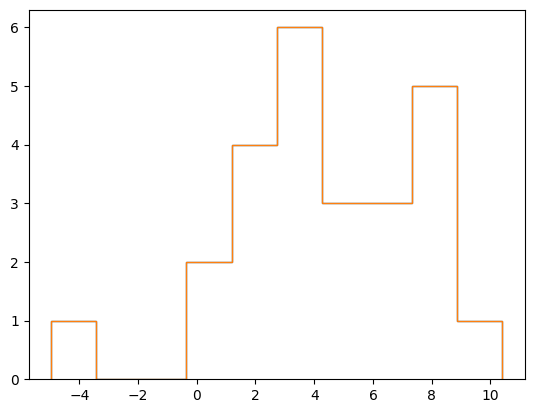

In [10]:
from matplotlib import pyplot as plt

ggdp_growth_percent = (finland_ggdp['ggdp_growth'].dropna(axis=0)) * 100

counts, bins = np.histogram(ggdp_growth_percent, bins=10)
plt.stairs(counts, bins)

ggdp_with_particulate_damage_growth = (finland_ggdp['ggdp_with_particulate_damage_growth'].dropna(axis=0)) * 100

counts, bins = np.histogram(ggdp_with_particulate_damage_growth, bins=10)
plt.stairs(counts, bins)

#summary statistics for ggdp

The data samples are quite limited because of different factors, so I'm thinking of ways of expanding the dataset. Every sample I can get is helpful now.
- CO2 emission cost - I can perhaps try to use the CO2 damage as GNI instead of pricing the damage myself. There is much more available data there as carbon tax only started being implemented in the early 90s.
- WTE - The limitation here is electricity price which goes only back to 1995. My main limitation is electricity price.
I need to expand electricity prices somehow.
I think it's worth checking the difference between the CO2 emission cost that I priced compared to that of the CO2 damage as GNI to see the difference.

 From WDI - Work Bank
 #### natural resources depletion
     Natural resource depletion is the sum of net forest depletion, energy depletion, and mineral depletion. Net forest depletion is unit resource rents times the excess of roundwood harvest over natural growth.
 #### Carbon Dioxide Damage
 	Cost of damage due to carbon dioxide emissions from fossil fuel use and the manufacture of cement, estimated to be US$40 per ton of CO2 (the unit damage in 2017 US dollars for CO2 emitted in 2020) times the number of tons of CO2 emitted.
 	my own opinion - it is calculated using a constant which can't really be constant over time because the cost of an emission of 1 kt of co2 in the 70s can't be the same as the cost it now because of the different environmental conditions that exist now, it is very unlikely to actually be a constant cost.
 #### Particulate Emission Damage
    Particulate emissions damage is the damage due to exposure of a country's population to ambient concentrations of particulates measuring less than 2.5 microns in diameter (PM2.5), ambient ozone pollution, and indoor concentrations of PM2.5 in households cooking with solid fuels.
    This perhaps can be included in the ggdp and maybe add a term for green innovation as well.

# GGDP - Calculating using imputated Electricity Prices
Add a bit of information accordingly

In [17]:
from data_reconstruction_functions import format_and_calculate_electricity_df

#loading non industrial imputated data
elec_hh_pre_2007_imputated = pd.read_csv('./ggdp_data/imputated_data/fi_hh_pre_2007_recovered.csv', header=0)
elec_hh_imputated = format_and_calculate_electricity_df(pre_2007_imputated_df=elec_hh_pre_2007_imputated,
                                    post_2007_df=elec_hh_post_2007_processed)

### loading industrial imputated data
elec_nh_pre_2007_imputated = pd.read_csv('./ggdp_data/imputated_data/fi_nh_pre_2007_recovered.csv', header=0)
elec_nh_imputated = format_and_calculate_electricity_df(pre_2007_imputated_df=elec_nh_pre_2007_imputated,
                                    post_2007_df=elec_nh_post_2007_processed)

C:\Users\yarde\PycharmProjects\ggdp_research\data_reconstruction_functions.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  elec_imputated = elec_imputated.replace(tax_tier_map)
C:\Users\yarde\PycharmProjects\ggdp_research\data_reconstruction_functions.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  elec_imputated = elec_imputated.replace(tax_tier_map)


In [19]:
from numpy import nan

from consumption_functions import calculate_energy_cost

finland_ggdp_imputated = pd.DataFrame()
#calculating GGDP with current data
#Calculating GGDP using base formula

#emission cost
#carbon tax is us$/ton of CO2
#perhaps need to convert this to ppp
finland_ggdp_imputated['co2_emission_cost_dollar'] = finland_data['finland_co2_kt'] * 1000 * finland_data['finland_carbon_tax']

#waste cost
#we used the existing wte dataframe that has data going back to 1990
#This is in EURO
finland_ggdp_imputated['waste_cost_eur'] = wte_df.apply(lambda x: calculate_energy_cost(wte=x['net_waste'],
                                                                                        year=x['year'], currency='EUR',
                                                                                        elec_consumption=elec_consump_processed,
                                                                                        hh_elec=elec_hh_imputated,
                                                                                        nh_elec=elec_nh_imputated)
                                                        , axis=1)

finland_ggdp_imputated = finland_ggdp_imputated.join(
    finland_data[['finland_dollar_to_lcu', 'finland_ppp_to_dollar', 'finland_as_particulate_emission_damage']])
finland_ggdp_imputated['waste_cost_dollar'] = finland_ggdp_imputated['waste_cost_eur'] * finland_ggdp_imputated[
    'finland_dollar_to_lcu']

#natural resource depltion cost in current dollar
finland_ggdp_imputated['natural_nrd_cost_dollar'] = finland_data['finland_as_nrd_cost']

#in current dollar
finland_ggdp_imputated['ggdp_dollar'] = finland_data['finland_gdp_dollar'] - finland_ggdp_imputated[
    'co2_emission_cost_dollar'] - \
                                        finland_ggdp_imputated['waste_cost_dollar'] - finland_ggdp_imputated[
                                            'natural_nrd_cost_dollar']

finland_ggdp_imputated['ggdp_ppp'] = finland_ggdp_imputated['ggdp_dollar'] * finland_ggdp_imputated[
    'finland_ppp_to_dollar']

#deducting particulate damage to see if it affects the ggdp at all
finland_ggdp_imputated['ggdp_dollar_adjusted_particulate_damage'] = finland_ggdp_imputated['ggdp_dollar'] - \
                                                                    finland_ggdp_imputated[
                                                                        'finland_as_particulate_emission_damage']
finland_ggdp_imputated['ggdp_ppp_adjusted_particulate_damage'] = finland_ggdp_imputated[
                                                                     'ggdp_dollar_adjusted_particulate_damage'] * \
                                                                 finland_ggdp_imputated['finland_ppp_to_dollar']

#I'm interested in gdp growth so the currency doesn't matter as long as it represents ppp and not only currency. PPP is local currency/dollar so I will calculate ggdp in lcu (local currency units) controlled for ppp and then when I calculate growth it becomes unitless but is adjusted for real terms.

#adding ppp_lcu_to_dollar_to_data_frame
#finland_ggdp = finland_ggdp.join(finland_data['finland_ppp_lcu_to_dollar'])
#finland_ggdp['ggdp_lcu'] = finland_ggdp['ggdp_dollar'] * finland_ggdp['finland_ppp_lcu_to_dollar']
finland_ggdp_imputated['ggdp_growth'] = finland_ggdp_imputated['ggdp_ppp'] / finland_ggdp_imputated['ggdp_ppp'].shift(
    1) - 1
finland_ggdp_imputated['ggdp_with_particulate_damage_growth'] = finland_ggdp_imputated[
                                                                    'ggdp_ppp_adjusted_particulate_damage'] / \
                                                                finland_ggdp_imputated[
                                                                    'ggdp_ppp_adjusted_particulate_damage'].shift(1) - 1



In [20]:
#summary statistics without particulate damage (not accounting for particulate damage)

imp_summary_stats = finland_ggdp_imputated['ggdp_growth'].describe()
imp_summary_stats['variance'] = finland_ggdp_imputated['ggdp_growth'].var()
imp_summary_stats['skewness'] = finland_ggdp_imputated['ggdp_growth'].skew()
imp_summary_stats['kurtosis'] = finland_ggdp_imputated['ggdp_growth'].kurtosis()

#summary stats with particulate damage (accounting for particulate damage)
imp_summary_stats_particulate = finland_ggdp_imputated['ggdp_with_particulate_damage_growth'].describe()
imp_summary_stats_particulate['variance'] = finland_ggdp_imputated['ggdp_with_particulate_damage_growth'].var()
imp_summary_stats_particulate['skewness'] = finland_ggdp_imputated['ggdp_with_particulate_damage_growth'].skew()
imp_summary_stats_particulate['kurtosis'] = finland_ggdp_imputated['ggdp_with_particulate_damage_growth'].kurtosis()

imp_merged_summary_stats = pd.concat([summary_stats, summary_stats_particulate], axis=1)
imp_merged_summary_stats


,ggdp_growth,ggdp_with_particulate_damage_growth
count,29.000000,29.000000
mean,0.042558,0.042578
std,0.033208,0.033208
min,-0.049226,-0.049232
25%,0.021661,0.021697
50%,0.039033,0.039054
75%,0.062154,0.062142
max,0.104064,0.104064
variance,0.001103,0.001103
skewness,-0.518030,-0.518553


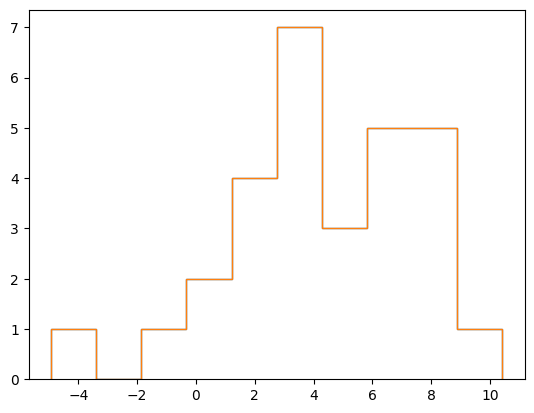

In [21]:
from matplotlib import pyplot as plt

ggdp_growth_percent = (finland_ggdp_imputated['ggdp_growth'].dropna(axis=0)) * 100

counts, bins = np.histogram(ggdp_growth_percent, bins=10)
plt.stairs(counts, bins)

ggdp_with_particulate_damage_growth = (finland_ggdp_imputated['ggdp_with_particulate_damage_growth'].dropna(
    axis=0)) * 100

counts, bins = np.histogram(ggdp_with_particulate_damage_growth, bins=10)
plt.stairs(counts, bins)

#summary statistics for ggdp

## Non-imputated data vs. Imputated data

In [ ]:
#plot both histograms together

#plot summary statistics together

#box plots for both data

In [15]:
# # how predictive is GDP for GGDP?
# 
# finland_ggdp_imputated = finland_ggdp_imputated.join(finland_data['finland_gdp_ppp'])
# finland_ggdp_imputated['gdp_growth'] = finland_ggdp_imputated['finland_gdp_ppp'] / finland_ggdp_imputated['finland_gdp_ppp'].shift(1) - 1
# 
# model = sm.OLS.from_formula('ggdp_growth ~ gdp_growth ', data=finland_ggdp)
# results = model.fit()
# results.summary()


GDP has no predictive power for predicting GGDP